In [1]:
# Install required packages for colab
!pip install mne
!pip install torch
!pip install matplotlib
!pip install scikit-learn
!pip install pandas
!pip install -U imbalanced-learn
!pip install keras-tuner
!pip install autoreject
!pip install --upgrade mne
!pip install joblib
!pip install librosa


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


# 1. Data Acquisition and Preprocessing
**Data Fetching and Loading:**

Fetches EEG data from the Sleep Physionet dataset.
Loads the raw EEG data and sleep stage annotations.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import librosa
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, GRU, Reshape, Dropout, LayerNormalization
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import mne
from mne.datasets.sleep_physionet.age import fetch_data
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
import seaborn as sns

# Set random seed for reproducibility
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

# Ensure deterministic behavior for CuDNN on GPU (if available)
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.enable_tensor_float_32_execution(False)
    try:
        tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    except RuntimeError as e:
        print(e)

mne.set_log_level('ERROR')

# Data acquisition and EEG signal processing
subjects = range(1, 2)
recordings = [1]
fnames = fetch_data(subjects=subjects, recording=recordings, on_missing='warn')


# Data Preprocessing:

Applies a notch filter to remove powerline noise.
Crops the data to focus on sleep stages.

In [3]:
def apply_cleanline(raw):
    raw.load_data()
    powerline_freq = 49.0
    notch_filter_params = dict(freqs=[powerline_freq], picks='eeg', filter_length='auto', verbose=False)
    raw.notch_filter(**notch_filter_params)
    return raw

def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True, crop_wake_mins=30):
    mapping = {'EOG horizontal': 'eog', 'Resp oro-nasal': 'misc', 'EMG submental': 'misc', 'Temp rectal': 'misc', 'Event marker': 'misc'}
    exclude = mapping.keys() if load_eeg_only else ()
    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=False)
    if not load_eeg_only:
        raw.set_channel_types(mapping)
    if crop_wake_mins > 0:
        mask = [x in {'Sleep stage 3', 'Sleep stage R', 'Sleep stage W', 'Sleep stage 4', 'Sleep stage 1', 'Movement time', 'Sleep stage 2'} for x in annots.description]
        sleep_event_inds = np.where(mask)[0]
        tmin = max(0, annots[int(sleep_event_inds[0])]['onset'] - crop_wake_mins * 60)
        tmax = annots[int(sleep_event_inds[-1])]['onset'] + crop_wake_mins * 60
        raw.crop(tmin=tmin, tmax=tmax)
    ch_names = {i: i.replace('EEG ', '') for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)
    basename = os.path.basename(raw_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}
    return raw

# Load sleep stage annotations
annotations = mne.read_annotations(fnames[0][1])
sleep_stages = annotations.description
numeric_labels = [int(stage[-1]) if stage[-1].isdigit() else 5 for stage in sleep_stages]

# Load raw data
raws = [load_sleep_physionet_raw(f[0], f[1], crop_wake_mins=30) for f in fnames]

# Apply cleanline for noise removal to each raw data
raws_cleaned = [apply_cleanline(raw) for raw in raws]


# Visualizing a raw EEG signal before and after cleaning

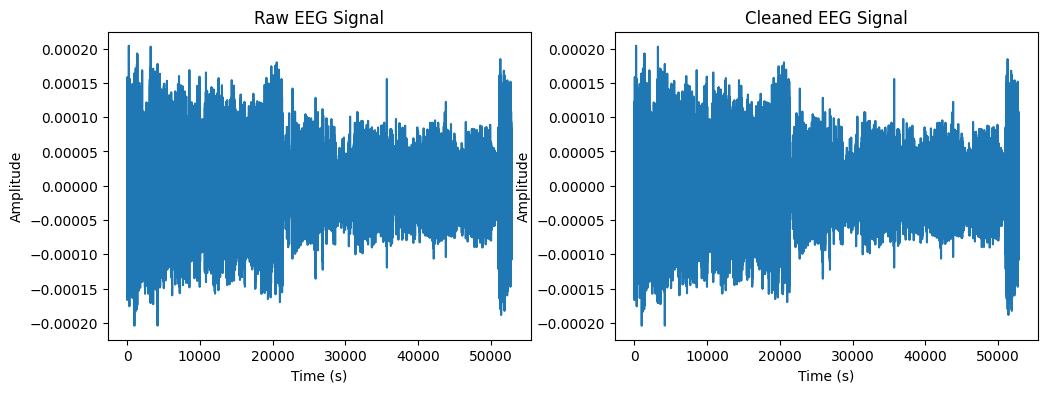

In [4]:
# Visualizing a raw EEG signal before and after cleaning
raw = raws[0]
raw_cleaned = raws_cleaned[0]

# Plotting raw EEG signal
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(raw.times, raw._data[0])
plt.title('Raw EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plotting cleaned EEG signal
plt.subplot(1, 2, 2)
plt.plot(raw_cleaned.times, raw_cleaned._data[0])
plt.title('Cleaned EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.show()


# 2. Signal Segmentation and Feature Extraction
Signal Segmentation:

Segments the EEG signals into overlapping windows.

In [5]:
window_size = 30
overlap = 0.5
sfreq = raws[0].info['sfreq']
n_samples = raws[0].n_times
start, stop = 0, int(window_size * sfreq)
step = int((1 - overlap) * window_size * sfreq)
segments = []

while stop < n_samples:
    segment, _ = raws[0][:, start:stop]
    segments.append(segment)
    start += step
    stop = start + int(window_size * sfreq)


# Visualizations
1. EEG Data Segmentation:

Visualizing segments of the EEG data.

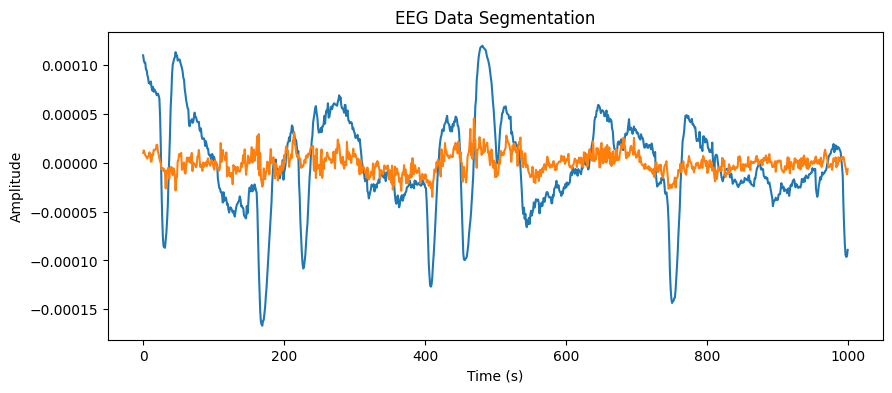

In [6]:
# Visualize EEG data segmentation
plt.figure(figsize=(10, 4))
plt.plot(raws[0][:, :int(10 * sfreq)][0].T)
plt.title("EEG Data Segmentation")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


# Feature Extraction:

Computes spectrograms, scalograms, and MFCCs for each segment.

In [7]:
def compute_features(segment, sfreq):
    f, t, Sxx = signal.spectrogram(segment[0], fs=sfreq, scaling='spectrum', axis=0)
    spectrogram = np.log1p(Sxx)

    widths = np.arange(1, 31)
    cwt_matr = signal.cwt(segment[0], signal.morlet2, widths)
    scalogram = np.log1p(np.abs(cwt_matr))

    mfccs = librosa.feature.mfcc(y=segment[0], sr=sfreq, n_mfcc=13)

    return spectrogram, scalogram, mfccs

features = []
for segment in segments:
    spectrogram, scalogram, mfccs = compute_features(segment, sfreq)

    # Resize spectrogram, scalogram, and MFCCs to the same shape
    target_shape = (129, 13)  # Example target shape
    spectrogram_resized = np.resize(spectrogram, target_shape)
    scalogram_resized = np.resize(scalogram, target_shape)
    mfccs_resized = np.resize(mfccs, target_shape)

    combined_image = np.stack((spectrogram_resized, scalogram_resized, mfccs_resized), axis=-1)
    features.append(combined_image)

features = np.array(features)
min_samples = min(len(features), len(numeric_labels))
features = features[:min_samples]
numeric_labels = numeric_labels[:min_samples]


# Spectrogram, Scalogram, and MFCCs:

Visualizing the computed features.

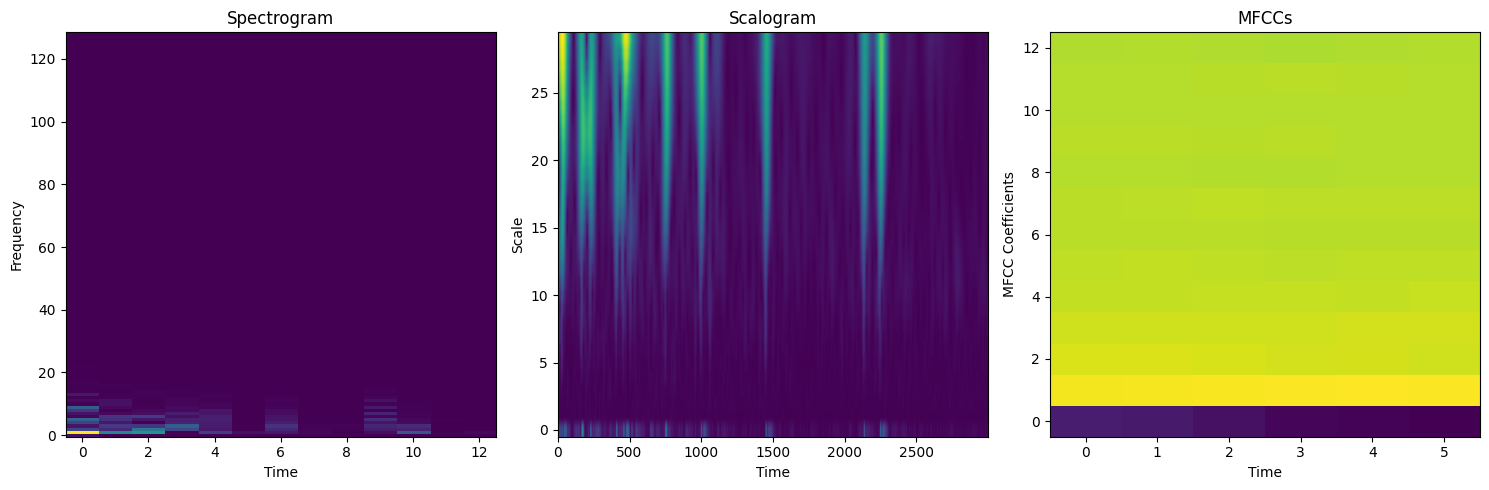

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Function to plot 2D images: spectrogram, scalogram, and MFCCs
def plot_2d_features(segment, sfreq):
    # Compute features
    spectrogram, scalogram, mfccs = compute_features(segment, sfreq)

    # Plot spectrogram
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    # Plot scalogram
    plt.subplot(1, 3, 2)
    plt.imshow(scalogram, aspect='auto', origin='lower')
    plt.title('Scalogram')
    plt.xlabel('Time')
    plt.ylabel('Scale')

    # Plot MFCCs
    plt.subplot(1, 3, 3)
    plt.imshow(mfccs, aspect='auto', origin='lower')
    plt.title('MFCCs')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')

    plt.tight_layout()
    plt.show()

# Visualize 2D features for the first segment
plot_2d_features(segments[0], sfreq)


# Function to plot 3D features

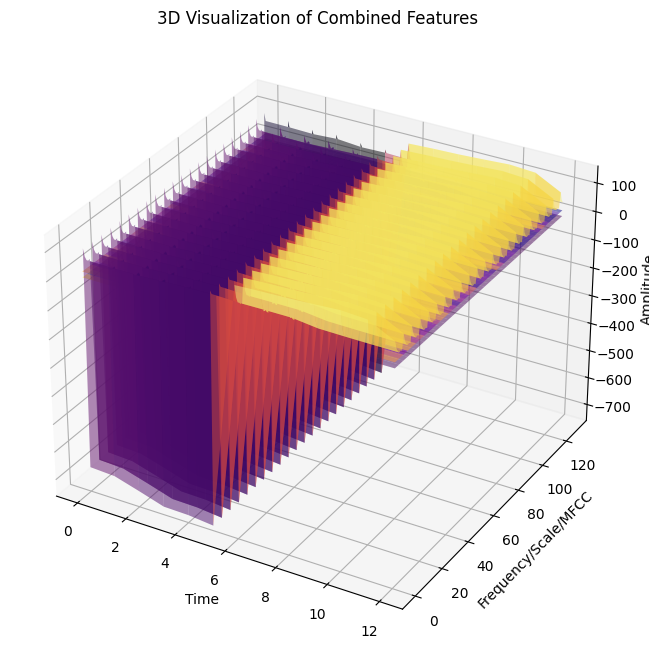

In [9]:
# Function to plot 3D features
def plot_3d_features(segment, sfreq):
    # Compute features
    spectrogram, scalogram, mfccs = compute_features(segment, sfreq)

    # Resize features to the same shape
    target_shape = (129, 13)  # Example target shape
    spectrogram_resized = np.resize(spectrogram, target_shape)
    scalogram_resized = np.resize(scalogram, target_shape)
    mfccs_resized = np.resize(mfccs, target_shape)

    # Stack features into a single 3D array
    combined_features = np.stack((spectrogram_resized, scalogram_resized, mfccs_resized), axis=-1)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create meshgrid
    x = np.arange(combined_features.shape[1])
    y = np.arange(combined_features.shape[0])
    X, Y = np.meshgrid(x, y)

    # Plot spectrogram
    Z_spectrogram = combined_features[:, :, 0]
    ax.plot_surface(X, Y, Z_spectrogram, cmap='viridis', edgecolor='none', alpha=0.5)

    # Plot scalogram
    Z_scalogram = combined_features[:, :, 1] + 20  # Offset to separate in 3D plot
    ax.plot_surface(X, Y, Z_scalogram, cmap='plasma', edgecolor='none', alpha=0.5)

    # Plot MFCCs
    Z_mfccs = combined_features[:, :, 2] + 40  # Offset to separate in 3D plot
    ax.plot_surface(X, Y, Z_mfccs, cmap='inferno', edgecolor='none', alpha=0.5)

    # Set plot labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency/Scale/MFCC')
    ax.set_zlabel('Amplitude')
    ax.set_title('3D Visualization of Combined Features')

    plt.show()

# Visualize 3D features for the first segment
plot_3d_features(segments[0], sfreq)


# 3. Handling Class Imbalance and Feature Scaling
Handling Class Imbalance:

Uses SMOTE to oversample the minority class.
Feature Scaling:

Scales the features using StandardScaler.

In [10]:
# Handling Class Imbalance and Feature Scaling
original_shape = features.shape  # Store original shape before flattening
features_flattened = features.reshape(features.shape[0], -1)
smote = SMOTE(random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features_flattened, numeric_labels)
min_samples_resampled = min(len(features_resampled), len(labels_resampled))
features_resampled = features_resampled[:min_samples_resampled]
labels_resampled = labels_resampled[:min_samples_resampled]

# Subtract 1 from labels to make them start from 0
labels_resampled = np.array(labels_resampled) - 1

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_resampled)

features_scaled_reshaped = features_scaled.reshape(-1, original_shape[1], original_shape[2], original_shape[3])


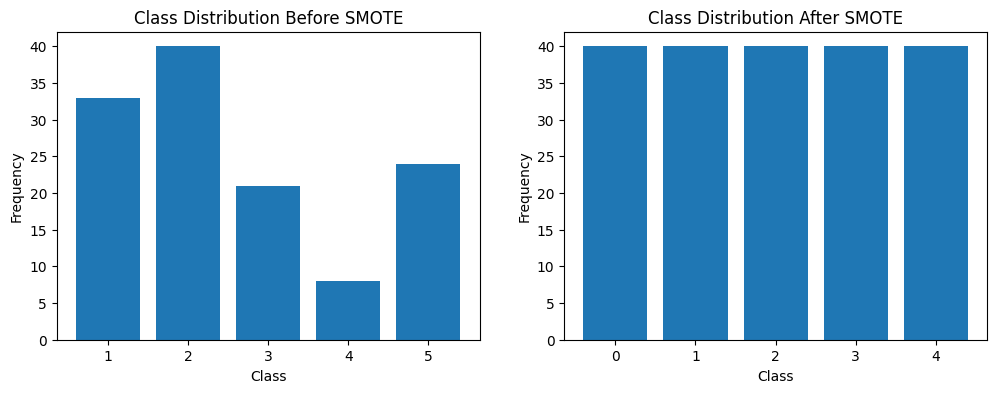

In [11]:
# Visualizing class distribution before and after SMOTE
unique, counts = np.unique(numeric_labels, return_counts=True)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(unique, counts)
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')

unique_resampled, counts_resampled = np.unique(labels_resampled, return_counts=True)
plt.subplot(1, 2, 2)
plt.bar(unique_resampled, counts_resampled)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()


# 4. Model Training
Transformer-Based Model:

Defines a custom transformer block and creates an enhanced MaxViT model.

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
def TransformerBlock(embed_dim, num_heads):
    inputs = layers.Input(shape=(None, embed_dim))
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention_output = layers.Dropout(0.1)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output + inputs)
    ffn_output = layers.Dense(embed_dim, activation='relu')(attention_output)
    ffn_output = layers.Dense(embed_dim)(ffn_output)
    ffn_output = layers.Dropout(0.1)(ffn_output)
    ffn_output = layers.LayerNormalization(epsilon=1e-6)(ffn_output + attention_output)
    return models.Model(inputs, ffn_output)

def enhanced_maxvit_model(input_shape, num_heads=4, transformer_embed_dim=128):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    shape_before_flattening = x.shape[1:]
    x = layers.Reshape((shape_before_flattening[0] * shape_before_flattening[1], 128))(x)

    transformer_block = TransformerBlock(embed_dim=transformer_embed_dim, num_heads=num_heads)
    x = transformer_block(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(5, activation='softmax')(x)

    # Define the learning rate
    learning_rate = 0.001

    # Define the optimizer with the specified learning rate
    optimizer = optimizers.Adam(learning_rate=learning_rate)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape_maxvit = features_scaled_reshaped.shape[1:]
enhanced_maxvit = enhanced_maxvit_model(input_shape_maxvit)


In [13]:
# Print the model summary
enhanced_maxvit.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 129, 13, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 129, 13, 64)       1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 65, 7, 64)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 7, 128)        73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 33, 4, 128)        0         
 g2D)                                                            
                                                                 
 reshape (Reshape)           (None, 132, 128)          0   

# GRU-Based Model:

Defines and creates a GRU-based model.

In [14]:
input_shape_gru = (original_shape[1], original_shape[2] * original_shape[3])

def build_gru_model(input_shape):
    model = Sequential()
    model.add(Reshape((input_shape[0], input_shape[1]), input_shape=input_shape))
    model.add(GRU(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add(GRU(64, return_sequences=False, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))
     # Define the learning rate
    learning_rate = 0.001

    # Define the optimizer with the specified learning rate
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer= optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

gru_model = build_gru_model(input_shape_gru)


In [15]:
#Get Model Summary
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 129, 39)           0         
                                                                 
 gru (GRU)                   (None, 129, 64)           20160     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 5)                 325       
                                                                 
Total params: 49605 (193.77 KB)
Trainable params: 49605 (193.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Train Test Split
Use 20 percent for testing and rest for the training.

In [16]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled_reshaped, labels_resampled, test_size=0.2, random_state=42)

# Training the Models:

Trains both the enhanced MaxViT and GRU models.

In [17]:
history_maxvit = enhanced_maxvit.fit(X_train, y_train, epochs=10000, batch_size=32, validation_split=0.2)



Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 128ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 6.1105 - val_accuracy: 0.5938
Epoch 7502/10000
4/4 [==============================] - 0s 127ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 6.1105 - val_accuracy: 0.5938
Epoch 7503/10000
4/4 [==============================] - 0s 127ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 6.1105 - val_accuracy: 0.5938
Epoch 7504/10000
4/4 [==============================] - 0s 127ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 6.1106 - val_accuracy: 0.5938
Epoch 7505/10000
4/4 [==============================] - 0s 132ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 6.1108 - val_accuracy: 0.5938
Epoch 7506/10000
4/4 [==============================] - 0s 127ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 6.1107 - val_accuracy: 0.5938
Epoch 7507/10000
4/4 [==============================] - 0s 130ms/s

In [18]:
history_gru = gru_model.fit(X_train.reshape(-1, original_shape[1], original_shape[2] * original_shape[3]), y_train, epochs=10000, batch_size=32, validation_split=0.2)

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 119ms/step - loss: 3.0648e-05 - accuracy: 1.0000 - val_loss: 4.9112 - val_accuracy: 0.6250
Epoch 7502/10000
4/4 [==============================] - 0s 126ms/step - loss: 3.7780e-05 - accuracy: 1.0000 - val_loss: 4.9110 - val_accuracy: 0.6250
Epoch 7503/10000
4/4 [==============================] - 0s 118ms/step - loss: 3.0025e-06 - accuracy: 1.0000 - val_loss: 4.9105 - val_accuracy: 0.6250
Epoch 7504/10000
4/4 [==============================] - 0s 124ms/step - loss: 7.6210e-06 - accuracy: 1.0000 - val_loss: 4.9102 - val_accuracy: 0.6250
Epoch 7505/10000
4/4 [==============================] - 1s 132ms/step - loss: 9.5614e-05 - accuracy: 1.0000 - val_loss: 4.9145 - val_accuracy: 0.6250
Epoch 7506/10000
4/4 [==============================] - 1s 139ms/step - loss: 4.5315e-06 - accuracy: 1.0000 - val_loss: 4.9173 - val_accuracy: 0.6250
Epoch 7507/10000
4/4 [==============================] - 0s 121ms/s

# 3. Model Training History:

Visualizing training history for accuracy and loss.

In [ ]:
# Plot training history for MaxViT model
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_maxvit.history['accuracy'], label='Train Accuracy')
plt.plot(history_maxvit.history['val_accuracy'], label='Val Accuracy')
plt.title('MaxViT Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_maxvit.history['loss'], label='Train Loss')
plt.plot(history_maxvit.history['val_loss'], label='Val Loss')
plt.title('MaxViT Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


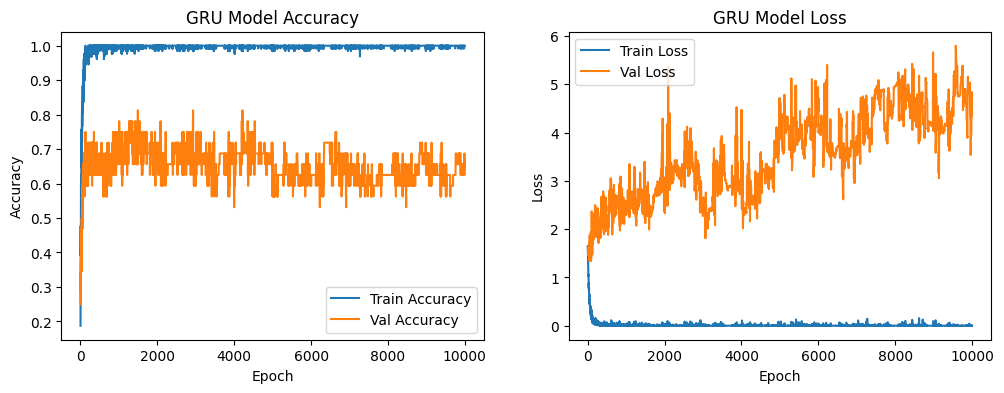

In [20]:
# Plot training history for GRU model
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Val Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 5. Model Evaluation and Ensemble
Model Prediction:

Uses the trained models to predict sleep stages.

In [21]:
maxvit_model_path = 'enhanced_maxvit_model.h5'
gru_model_path = 'gru_model.h5'
enhanced_maxvit.save(maxvit_model_path)
gru_model.save(gru_model_path)

# Load saved models
enhanced_maxvit = load_model(maxvit_model_path)
gru_model = load_model(gru_model_path)

# Use models for prediction
y_pred_maxvit = np.argmax(enhanced_maxvit.predict(X_test), axis=-1)
y_pred_gru = np.argmax(gru_model.predict(X_test.reshape(-1, original_shape[1], original_shape[2] * original_shape[3])), axis=-1)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 29ms/step


# Ensemble with AdaBoost:

Combines predictions using AdaBoost classifier for better accuracy.

In [22]:
# Combine predictions using AdaBoost
combined_predictions = np.column_stack((y_pred_maxvit, y_pred_gru))
ada_boost_classifier = AdaBoostClassifier(n_estimators=1000, random_state=42)
ada_boost_classifier.fit(combined_predictions, y_test)

# Evaluate AdaBoost Classifier
combined_accuracy = ada_boost_classifier.score(combined_predictions, y_test)
print(f'AdaBoost Classifier Accuracy: {combined_accuracy}')


AdaBoost Classifier Accuracy: 0.6


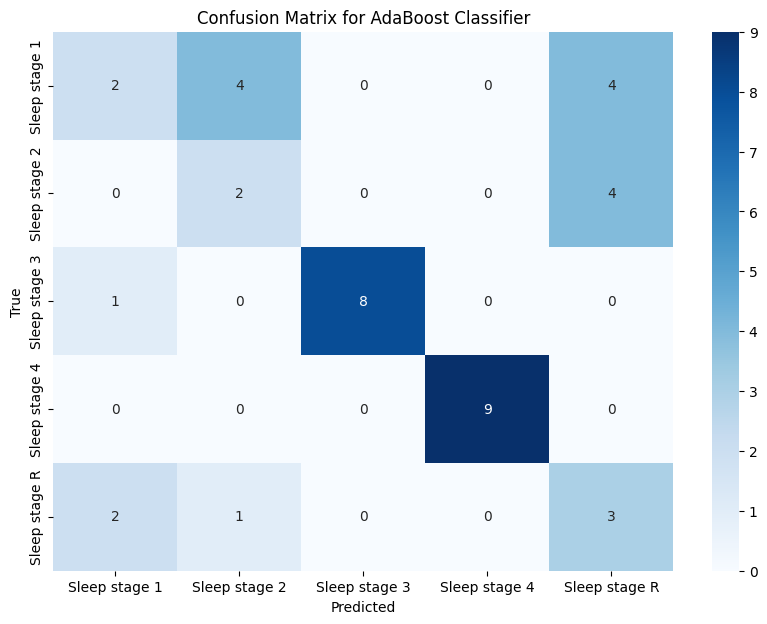

In [23]:
# Define class names based on your dataset
class_names = ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R']


# Predict on the test set using AdaBoost Classifier
y_pred_ada = ada_boost_classifier.predict(combined_predictions)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_ada)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for AdaBoost Classifier')
plt.show()




In [24]:
# Classification report
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_ada, target_names=class_names)
print('Classification Report for AdaBoost Classifier:')
print(report)

Classification Report for AdaBoost Classifier:
               precision    recall  f1-score   support

Sleep stage 1       0.40      0.20      0.27        10
Sleep stage 2       0.29      0.33      0.31         6
Sleep stage 3       1.00      0.89      0.94         9
Sleep stage 4       1.00      1.00      1.00         9
Sleep stage R       0.27      0.50      0.35         6

     accuracy                           0.60        40
    macro avg       0.59      0.58      0.57        40
 weighted avg       0.63      0.60      0.60        40



In [25]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [26]:
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5, 2.0],
    'base_estimator__max_depth': [1, 2, 3, 4, 5, 6],
    'base_estimator__min_samples_split': [2, 5, 10],
    'algorithm': ['SAMME', 'SAMME.R']
}


In [27]:
base_estimator = DecisionTreeClassifier(random_state=42)
ada_boost = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)


In [28]:
grid_search = GridSearchCV(estimator=ada_boost, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(combined_predictions, y_test)


Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                                          random_state=42),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator__max_depth': [1, 2, 3, 4, 5, 6],
                         'base_estimator__min_samples_split': [2, 5, 10],
                         'learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5, 2.0],
                         'n_estimators': [50, 100, 200, 300, 400, 500]},
             scoring='accuracy', verbose=2)

Best AdaBoost Classifier Accuracy: 0.8
Best AdaBoost Classifier Parameters: {'algorithm': 'SAMME', 'base_estimator__max_depth': 4, 'base_estimator__min_samples_split': 2, 'learning_rate': 0.5, 'n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.67      0.33      0.44         6
           2       0.90      1.00      0.95         9
           3       1.00      1.00      1.00         9
           4       0.75      0.50      0.60         6

    accuracy                           0.80        40
   macro avg       0.79      0.75      0.75        40
weighted avg       0.80      0.80      0.78        40



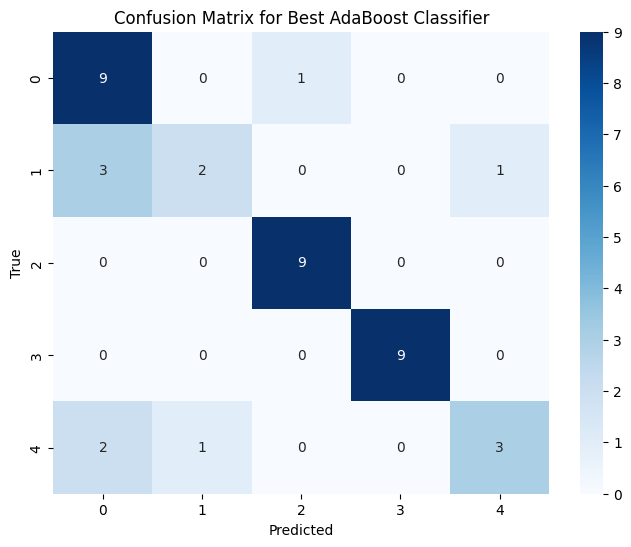

In [29]:
# Get the best model from grid search
best_ada_boost = grid_search.best_estimator_

# Make predictions on the test set
y_pred_best = best_ada_boost.predict(combined_predictions)

# Evaluate the model
accuracy_best = accuracy_score(y_test, y_pred_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)
class_report_best = classification_report(y_test, y_pred_best)

# Print evaluation results
print(f'Best AdaBoost Classifier Accuracy: {accuracy_best}')
print('Best AdaBoost Classifier Parameters:', grid_search.best_params_)
print('Classification Report:\n', class_report_best)

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best AdaBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
